Import các thư viện cần thiết:

In [10]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, silhouette_score
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import random
%matplotlib inline

Hàm để đọc dữ liệu tất cả ảnh có trong đường dẫn được truyền vào, đầu ra gồm ma trận mxn (m ảnh, n features) và mảng chứa class tương ứng với từng ảnh:

In [2]:
ROWS = 150
COLUMNS = 150
CHANNELS = 3
# CHANNELS = 1


# Function to read image and convert to the specified size
def read_image(file_path):
    # return cv2.resize(cv2.imread(file_path, cv2.IMREAD_GRAYSCALE), (ROWS, COLUMNS), cv2.INTER_AREA).flatten()
    return cv2.resize(cv2.imread(file_path, cv2.IMREAD_COLOR), (ROWS, COLUMNS), cv2.INTER_AREA).flatten()


def get_image_path(path):
    images = []
    categories = []

    # Get the list of class folders
    class_folders = os.listdir(path)

    # Iterate over each class folder
    for class_folder in class_folders:
        # Get the path to the current class folder
        class_folder_path = os.path.join(path, class_folder)

        # Get the list of image files in the class folder
        image_files = os.listdir(class_folder_path)

        # Iterate over each image file
        for image_file in image_files:
            # Get the path to the current image file
            image_file_path = os.path.join(class_folder_path, image_file)
            images.append(image_file_path)
            categories.append(class_folder)

    return images, categories


def get_data(path):
    images, categories = get_image_path(path)

    X = np.zeros((len(images), ROWS * COLUMNS * CHANNELS))

    for i, image_path in enumerate(tqdm(images)):
        X[i, :] = read_image(image_path)

    return X, np.array(categories)

Đọc dữ liệu training và validation:

In [3]:
X_train, y_train = get_data('datav2/train/')
X_valid, y_valid = get_data('datav2/validation/')
X_test, y_test = get_data('datav2/test/')

100%|██████████| 996/996 [00:01<00:00, 924.28it/s]


In [4]:
X_train.shape

(5000, 67500)

In [5]:
X_valid.shape

(2500, 67500)

In [6]:
X_test.shape

(996, 67500)

Chuẩn hóa dữ liệu bằng cách thay đổi các giá trị điểm ảnh (khoảng 0-255) về khoảng 0-1

In [7]:
# Standardizing the dataset
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test / 255.

Giảm chiều dữ liệu

In [8]:
# Create an instance of PCA with n_components=225
pca = PCA(n_components=225)

# Fit the PCA model to the data and transform the data
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.fit_transform(X_valid)
X_test_pca = pca.transform(X_test)

# Print the amount of lost information
print("Lost information: {:.2f}%".format((1 - sum(pca.explained_variance_ratio_)) * 100))

Lost information: 8.96%


Lưu dữ liệu để sử dụng lần sau:

In [9]:
np.save('X_train.npy', X_train)
np.save('X_valid.npy', X_valid)
np.save('X_test.npy', X_test)
np.save('X_train_pca.npy', X_train_pca)
np.save('X_valid_pca.npy', X_valid_pca)
np.save('X_test_pca.npy', X_test_pca)
np.save('y_train.npy', y_train)
np.save('y_valid.npy', y_valid)
np.save('y_test.npy', y_test)

Load lại dữ liệu đã lưu

In [3]:
X_train = np.load('X_train.npy')
X_valid = np.load('X_valid.npy')
X_test = np.load('X_test.npy')
X_train_pca = np.load('X_train_pca.npy')
X_valid_pca = np.load('X_valid_pca.npy')
X_test_pca = np.load('X_test_pca.npy')
y_train = np.load('y_train.npy')
y_valid = np.load('y_valid.npy')
y_test = np.load('y_test.npy')

In [11]:
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)

2) Thực hiện thay đổi hợp lý trên giữ liệu, sau đó thực hiện phân cụm (clustering) dữ liệu gốc bằng 01 thuật toán phân cụm. Hiển thị trực quan và đánh dấu các cụm.

In [4]:
def plot_cf_heatmap(y_true, y_pred):
    data = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sn.set_theme(font_scale=1.4) # for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [5]:
# Define the clustering algorithms
algorithms = {
    'KMeans': KMeans(n_clusters=5, random_state=0),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=5),
    'GaussianMixture': GaussianMixture(n_components=5, random_state=0),
}

In [6]:
for name, algorithm in algorithms.items():
    print(name)
    # Fit the algorithm to the data
    algorithm.fit(X_train_pca)

KMeans
AgglomerativeClustering
GaussianMixture


In [7]:
from collections import Counter

def find_most_common_labels(clusters):
    most_common_labels = {}
    for cluster in range(5):
        cluster_labels = y_train[clusters == cluster]
        most_common_label = Counter(cluster_labels).most_common(1)[0][0]
        most_common_labels[cluster] = most_common_label
    return most_common_labels

In [8]:
common_labels = {}

for name, algorithm in algorithms.items():
    # Predict the cluster for each data point
    if name == 'GaussianMixture':
        clusters = algorithm.predict(X_train_pca)
    else:
        clusters = algorithm.labels_

    # Find the most common label for each cluster
    common_labels[name] = find_most_common_labels(clusters)
    
for name, common_labels_ in common_labels.items():
    print(name, end=' ')
    print(common_labels_)

KMeans {0: 'Mouse', 1: 'Cow', 2: 'Dog', 3: 'Panda', 4: 'Cat'}
AgglomerativeClustering {0: 'Mouse', 1: 'Dog', 2: 'Cat', 3: 'Panda', 4: 'Cow'}
GaussianMixture {0: 'Mouse', 1: 'Cow', 2: 'Dog', 3: 'Panda', 4: 'Cat'}


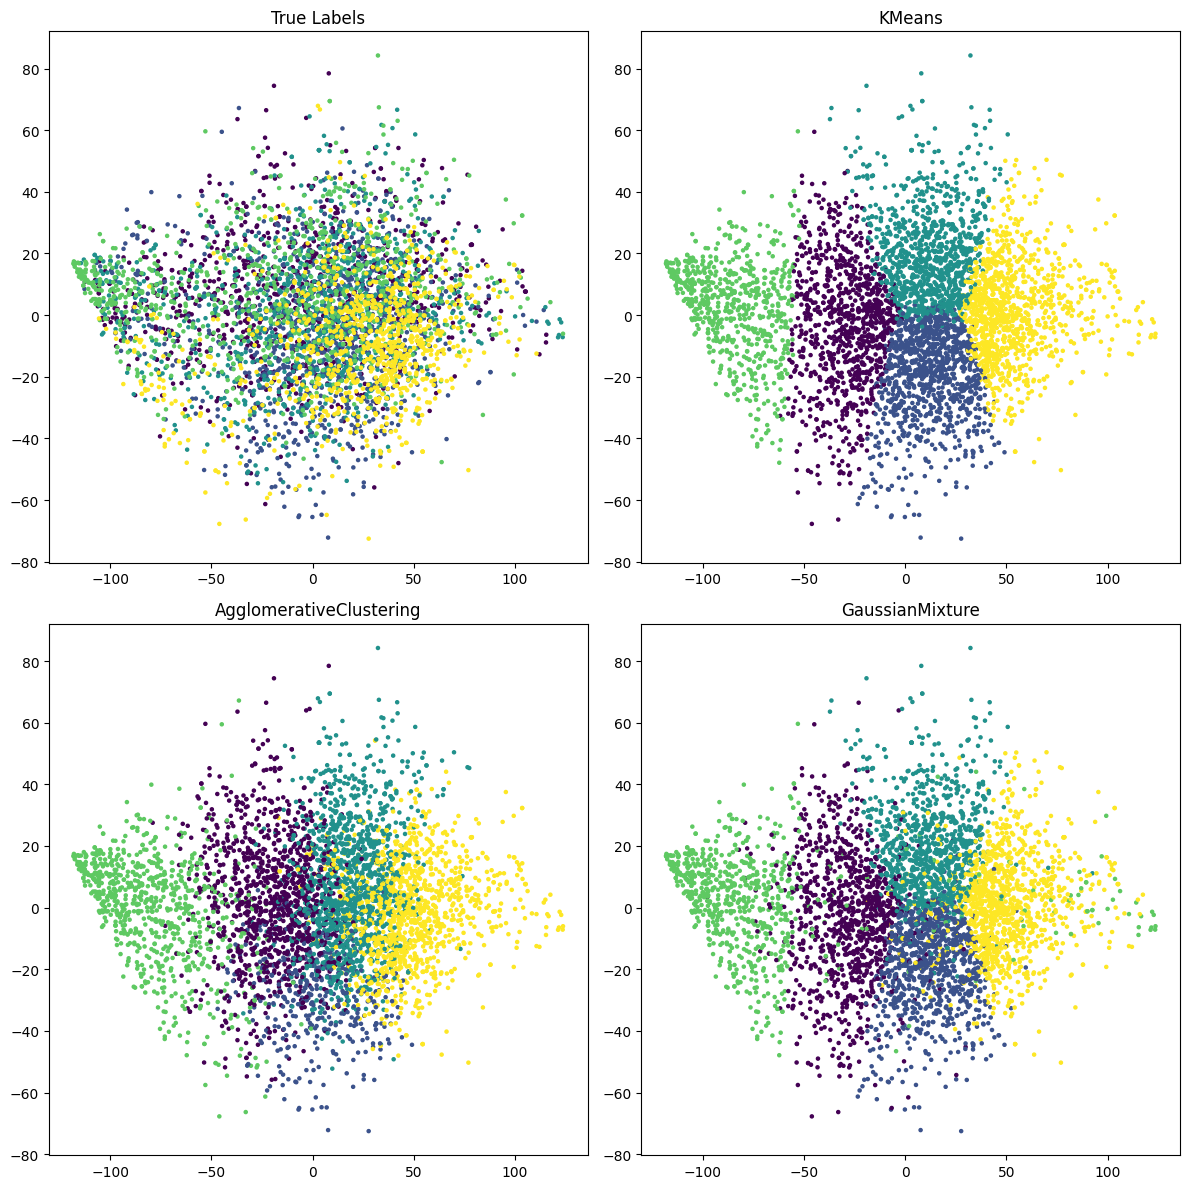

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot the true labels
axs[0, 0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_encoded, s=5)
axs[0, 0].set_title('True Labels')

# Apply each clustering algorithm and plot the results
for i, (name, algorithm) in enumerate(algorithms.items(), start=1):
    if name == 'GaussianMixture':
        clusters = algorithm.predict(X_train_pca)
    else:
        clusters = algorithm.labels_
        
    y_pred = [common_labels[name][cluster] for cluster in clusters]
    y_pred_encoded = le.transform(y_pred)
    # Plot the results
    axs[i // 2, i % 2].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_pred_encoded, s=5)
    axs[i // 2, i % 2].set_title(name)

plt.tight_layout()
plt.show()

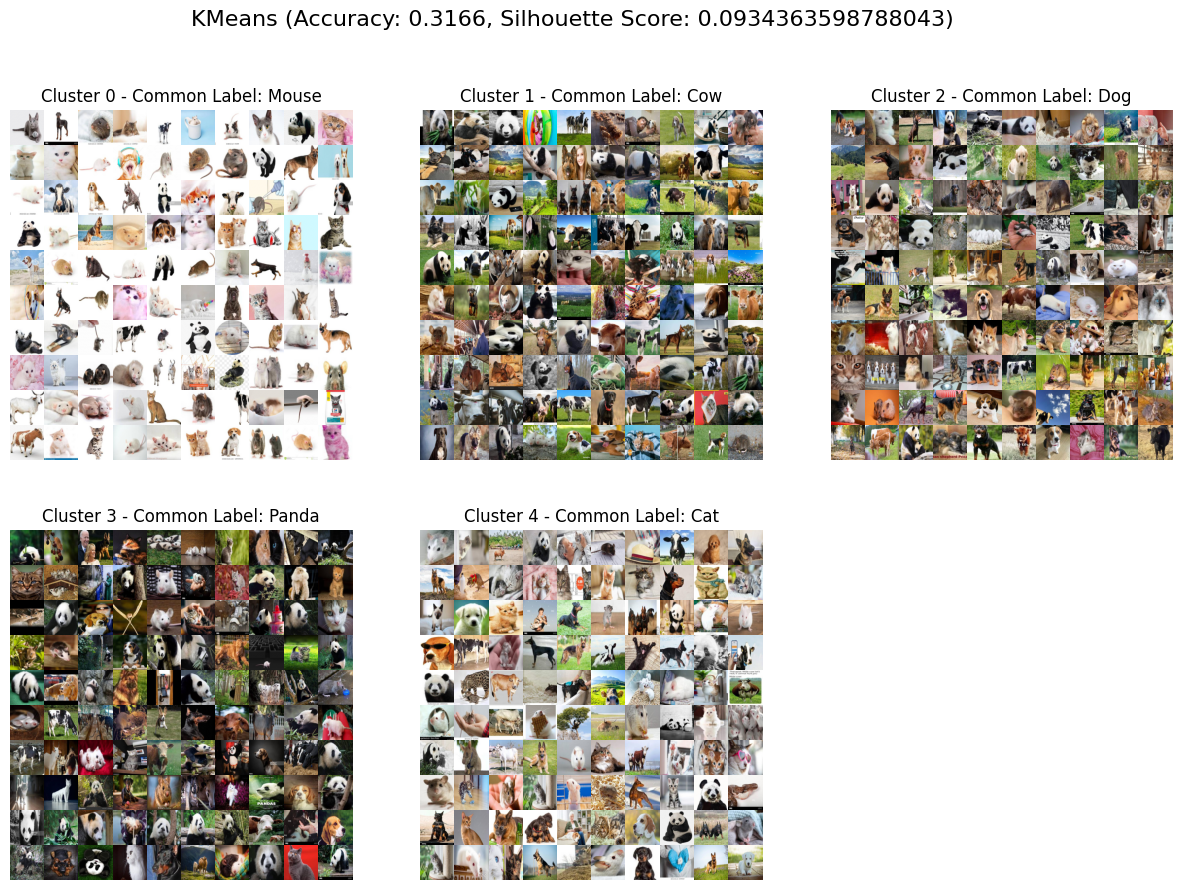

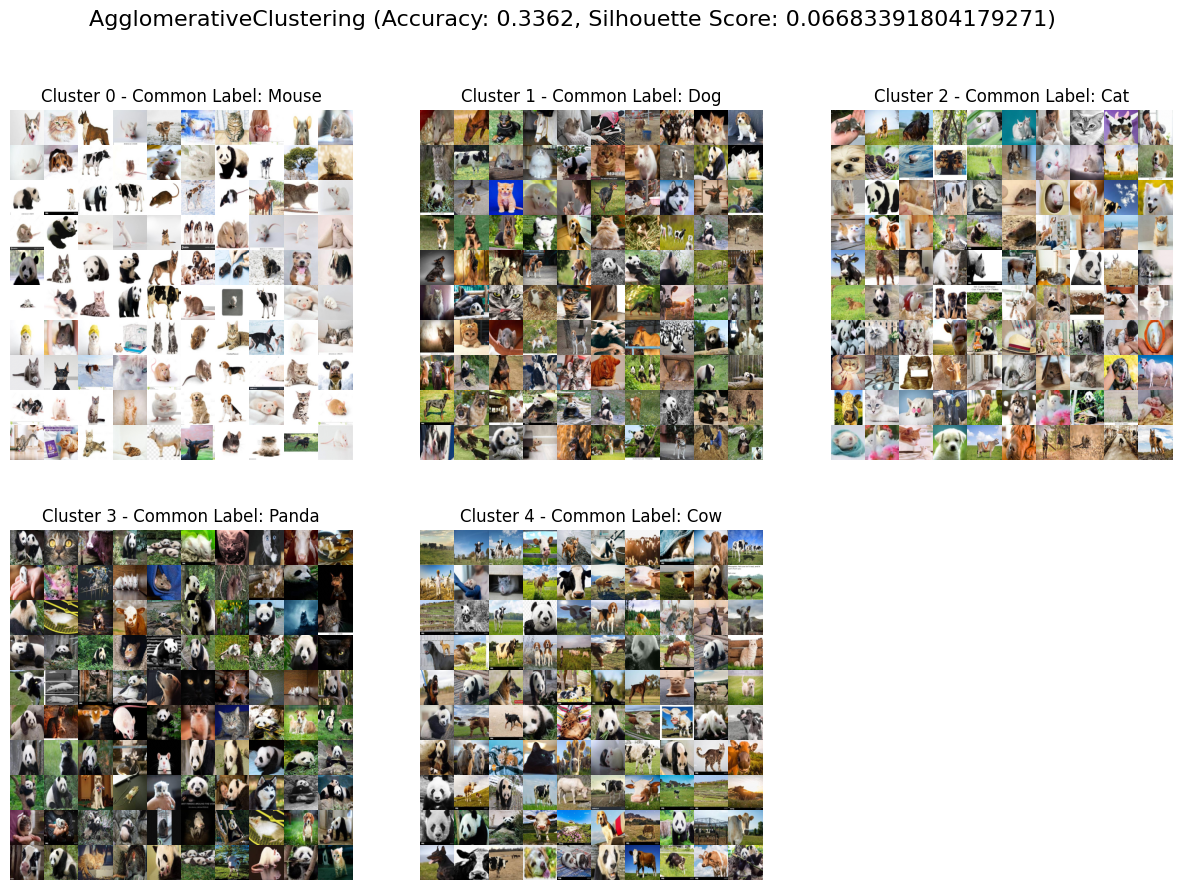

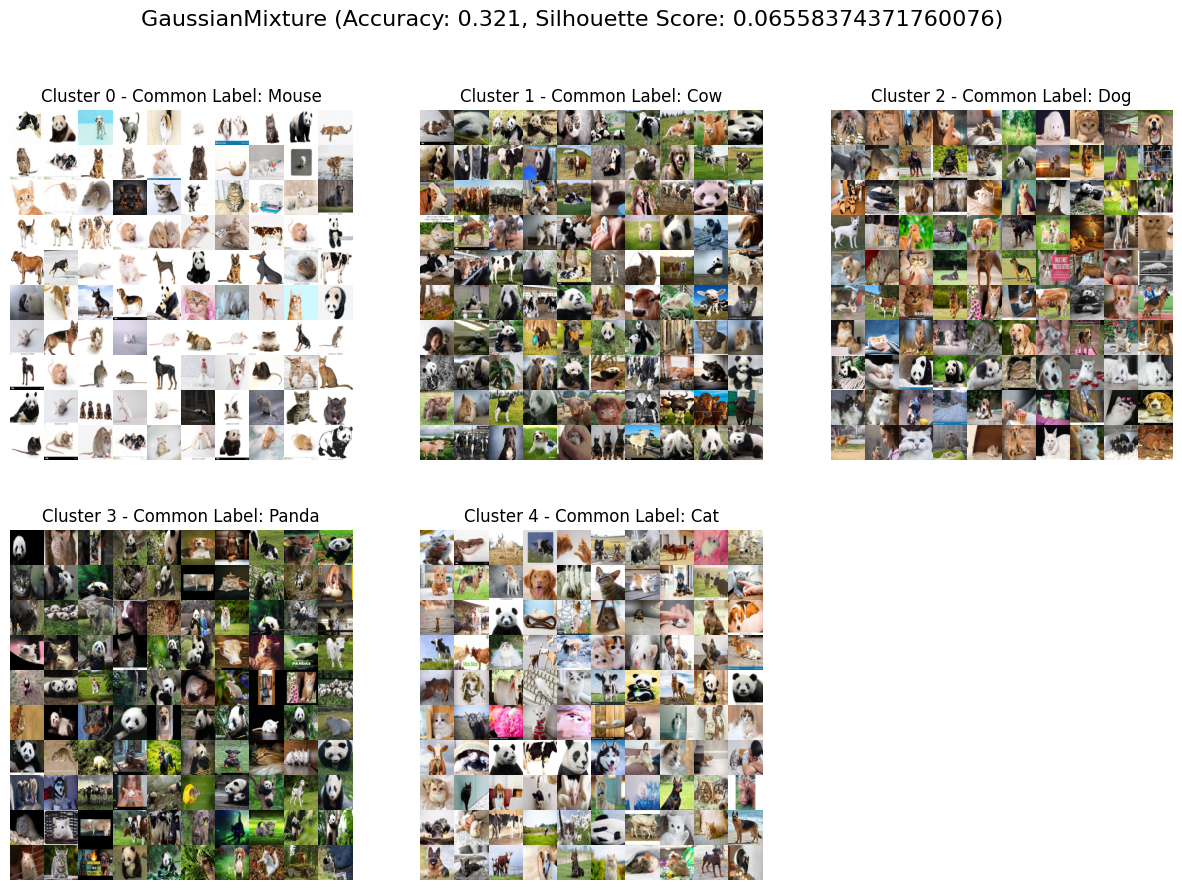

In [9]:
for name, algorithm in algorithms.items():
    if name == 'GaussianMixture':
        clusters = algorithm.predict(X_train_pca)
    else:
        clusters = algorithm.labels_
        
    y_pred = [common_labels[name][cluster] for cluster in clusters]

    # Create a 3x2 grid of subplots
    fig, big_axes = plt.subplots(2, 3, figsize=(15, 10))
    accuracy = accuracy_score(y_train, y_pred)
    silhouette = silhouette_score(X_train_pca, clusters)
    fig.suptitle(f'{name} (Accuracy: {accuracy}, Silhouette Score: {silhouette})', fontsize=16)

    # Iterate over the big axes to create a 10x10 grid in each one
    for i, big_ax in enumerate(big_axes.flat, 1):
        big_ax.axis('off')
        if i == 6: break
        big_ax.set_title(f'Cluster {i-1} - Common Label: {common_labels[name][i-1]}')
        
        # Get the indices of images in the selected cluster
        cluster_indices = np.where(clusters == i-1)[0]
        cluster_size = cluster_indices.shape[0]
        # Select random 100 indices from the cluster
        random_indices = random.sample(list(cluster_indices), 100 if cluster_size > 100 else cluster_size)
        
        for j in range(10):
            for k in range(10):
                small_ax = big_ax.inset_axes([(j/10), (k/10), 0.1, 0.1])
                if j * 10 + k < len(random_indices):
                    small_ax.imshow(X_train[random_indices[j * 10 + k]].reshape(ROWS, COLUMNS, CHANNELS)[:,:,::-1])
                small_ax.axis('off')
    plt.show()

5) Xây dựng chương trình sử dụng mô hình Multi-Classes Support Vector Machine để phân loại các hình ảnh, huấn luyện mô hình bằng tập dữ liệu training sau đó chạy kiểm tra với dữ liệu trong tập validation.

In [8]:
kernels = {'liner': svm.SVC(kernel='linear'),
           'sigmoid': svm.SVC(kernel='sigmoid'),
           'poly': svm.SVC(kernel='poly'),
           'rdf': svm.SVC(kernel='rbf')}

# fit the model
for kernel, model in kernels.items():
    model.fit(X_train, y_train)

In [16]:
def save_model(model_name, model):
    with open(f'{model_name}.pkl','wb') as f:
        pickle.dump(model,f)

In [17]:
for model_name, model in kernels.items():
    save_model(model_name, model)

Model: liner
              precision    recall  f1-score   support

         Cat       0.32      0.33      0.33       500
         Cow       0.46      0.36      0.40       500
         Dog       0.48      0.49      0.49       500
       Mouse       0.49      0.69      0.57       500
       Panda       0.67      0.49      0.57       500

    accuracy                           0.47      2500
   macro avg       0.48      0.47      0.47      2500
weighted avg       0.48      0.47      0.47      2500

Model: sigmoid


c:\Users\imlda\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\imlda\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\imlda\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         Cat       0.16      0.33      0.22       500
         Cow       0.16      0.36      0.22       500
         Dog       0.00      0.00      0.00       500
       Mouse       0.16      0.11      0.13       500
       Panda       0.00      0.00      0.00       500

    accuracy                           0.16      2500
   macro avg       0.10      0.16      0.11      2500
weighted avg       0.10      0.16      0.11      2500

Model: poly
              precision    recall  f1-score   support

         Cat       0.43      0.35      0.38       500
         Cow       0.55      0.44      0.49       500
         Dog       0.49      0.55      0.52       500
       Mouse       0.54      0.72      0.62       500
       Panda       0.68      0.65      0.67       500

    accuracy                           0.54      2500
   macro avg       0.54      0.54      0.54      2500
weighted avg       0.54      0.54      0.54      2500

Model: rdf

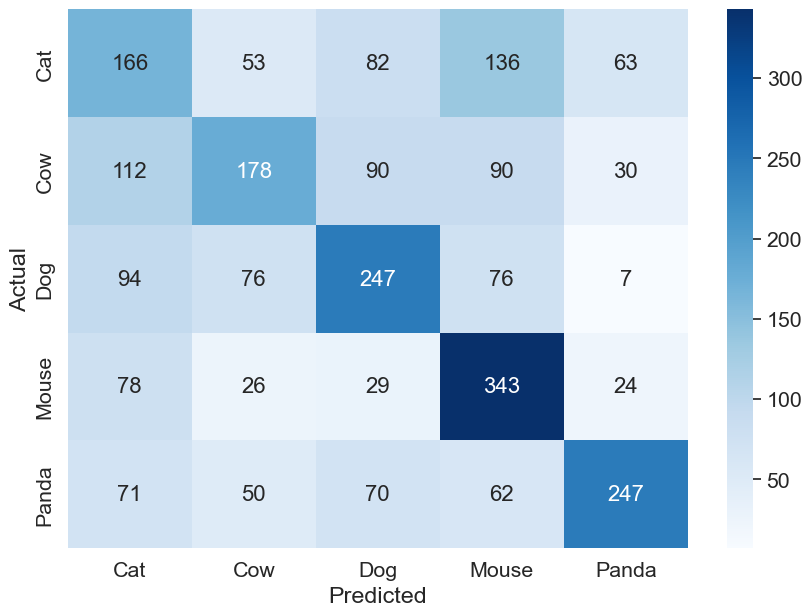

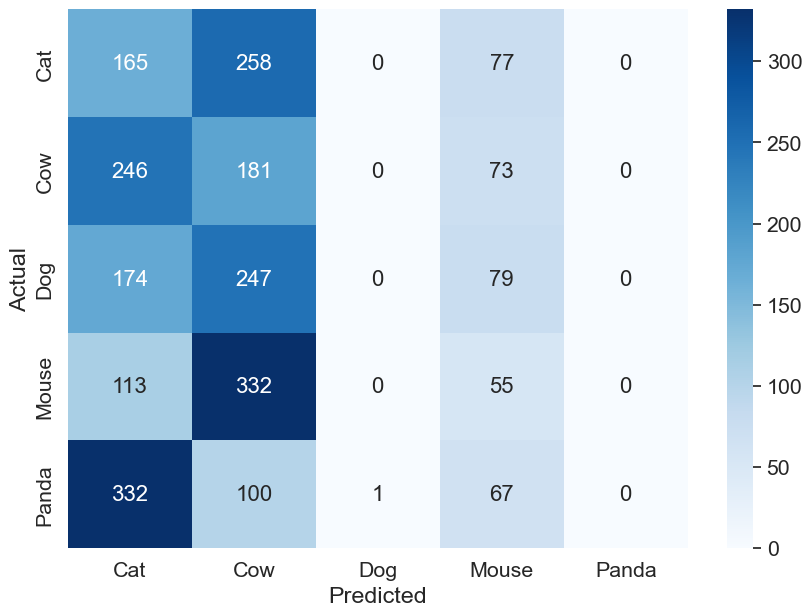

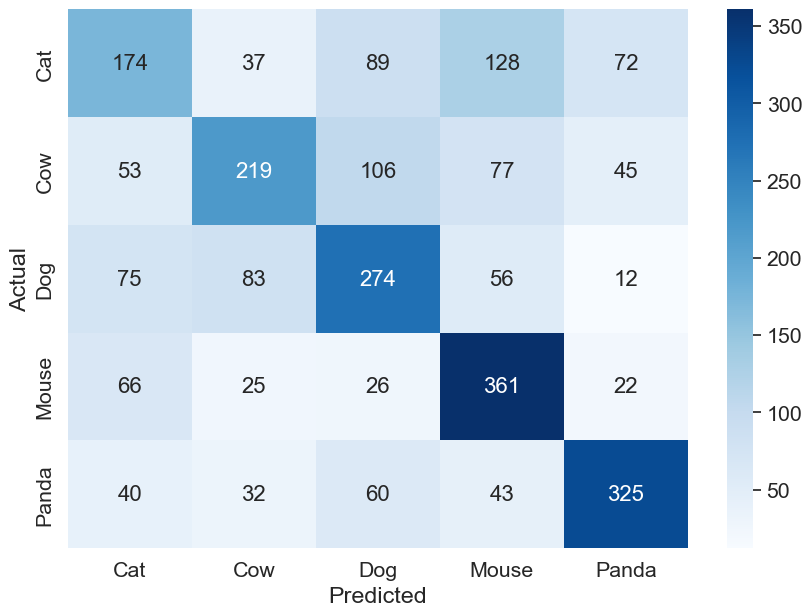

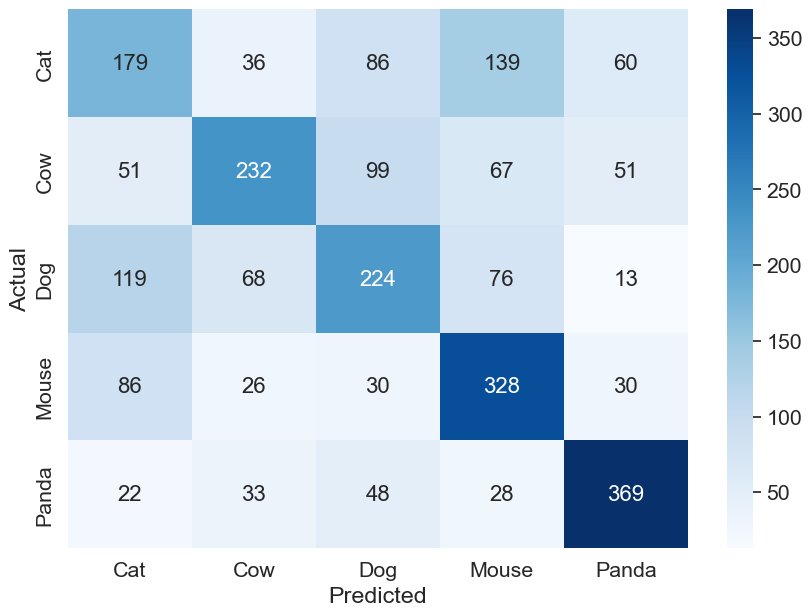

In [21]:
for model_name, model in kernels.items():
    print(f"Model: {model_name}")
    y_pred = model.predict(X_valid)
    plot_cf_heatmap(y_valid, y_pred)
    print(classification_report(y_valid, y_pred))

Thử với dữ liệu giảm chiều

In [54]:
kernels_pca = {'liner': svm.SVC(kernel='linear', C=0.1),
           'sigmoid': svm.SVC(kernel='sigmoid'),
           'poly': svm.SVC(kernel='poly'),
           'rdf': svm.SVC(kernel='rbf')}

# fit the model
for kernel, model in kernels_pca.items():
    model.fit(X_train_pca, y_train)

Model: liner
              precision    recall  f1-score   support

         Cat       0.20      0.21      0.21       500
         Cow       0.27      0.32      0.29       500
         Dog       0.25      0.25      0.25       500
       Mouse       0.21      0.18      0.20       500
       Panda       0.32      0.30      0.31       500

    accuracy                           0.25      2500
   macro avg       0.25      0.25      0.25      2500
weighted avg       0.25      0.25      0.25      2500

Model: sigmoid
              precision    recall  f1-score   support

         Cat       0.16      0.34      0.22       500
         Cow       0.20      0.34      0.25       500
         Dog       0.23      0.05      0.08       500
       Mouse       0.14      0.06      0.08       500
       Panda       0.31      0.16      0.21       500

    accuracy                           0.19      2500
   macro avg       0.21      0.19      0.17      2500
weighted avg       0.21      0.19      0.17      

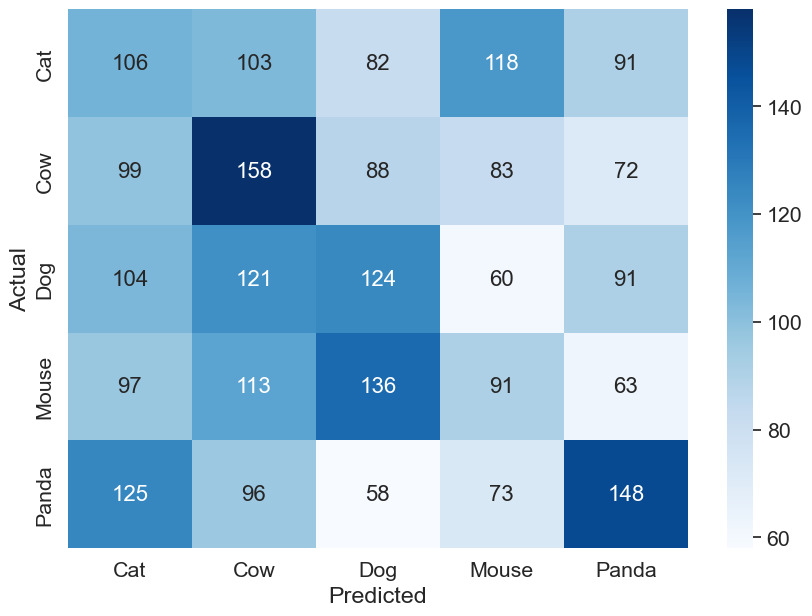

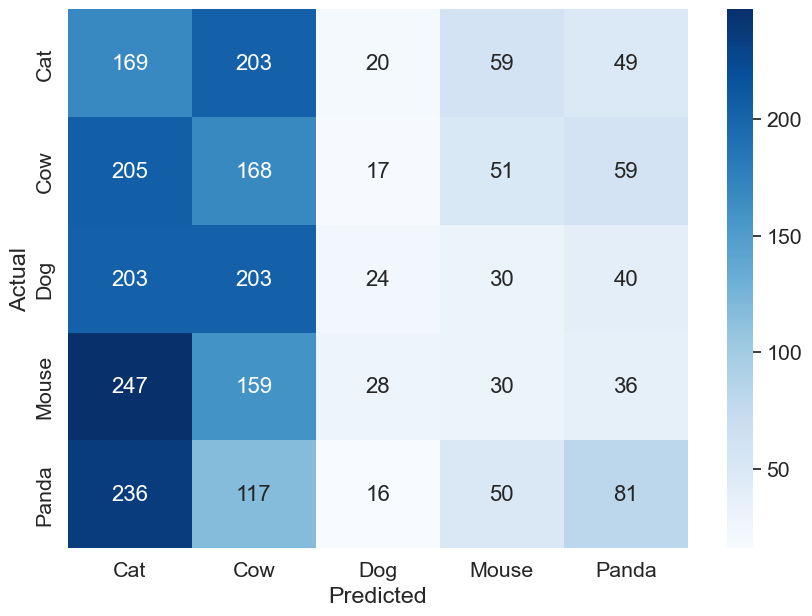

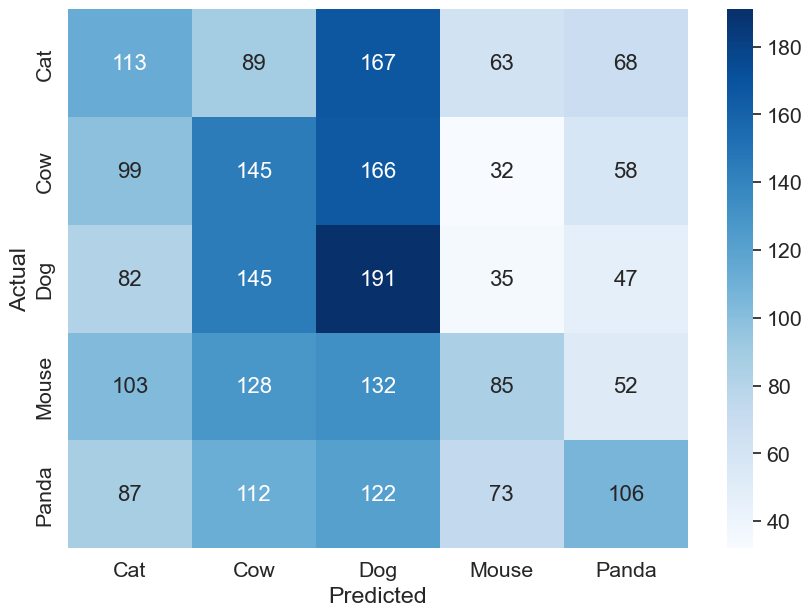

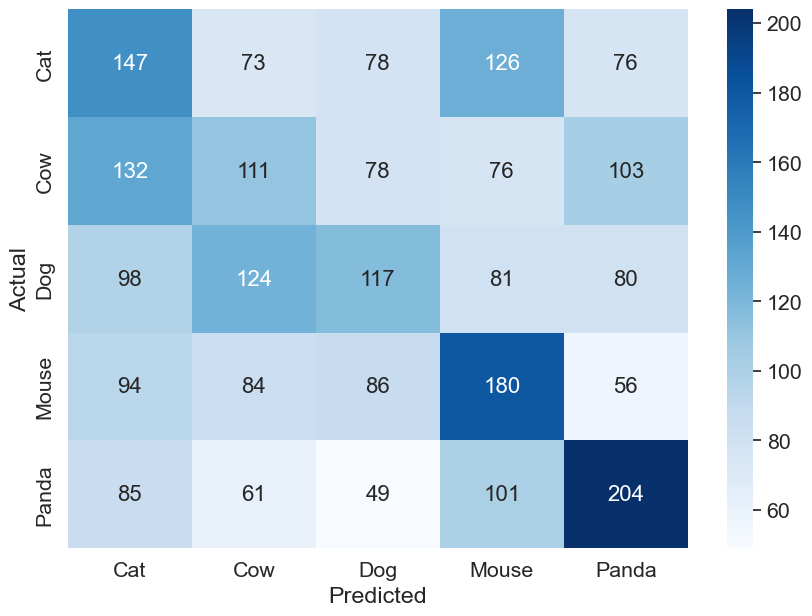

In [55]:
for model_name, model in kernels_pca.items():
    print(f"Model: {model_name}")
    y_pred = model.predict(X_valid_pca)
    plot_cf_heatmap(y_valid, y_pred)
    print(classification_report(y_valid, y_pred))